In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Set up the date range
idx = pd.date_range(start='2023-01-01', end='2023-01-07', freq="h")

In [4]:
# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

In [5]:
# Define the average wait times in minutes
mean_wait_time = 60

In [6]:
# Create a sine curve to reflect the changing average wait times throughout the day
# Simulate lower wait times during early morning and late night, higher in afternoon and evening
x = np.linspace(-np.pi, np.pi, 24)
means = (np.sin(x) * (mean_wait_time / 3)) + mean_wait_time

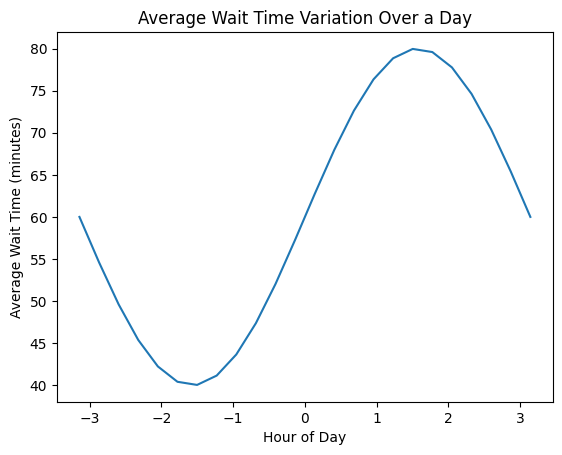

In [7]:
# Plot to visualize the average wait time pattern over a 24-hour period
plt.plot(x, means)
plt.title("Average Wait Time Variation Over a Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.show()

In [8]:
# Calculate the appropriate length of time series
number_of_days = len(idx) / 24
multiplier = (number_of_days * 2) - 1

In [9]:
# Expand the sine wave pattern to match the total number of data points in hours
x_extended = np.linspace(-np.pi, multiplier * np.pi, len(idx))
wait_time_means = (np.sin(x_extended) * (mean_wait_time / 3)) + mean_wait_time

In [10]:
# Generate wait times based on the Poisson distribution
df = pd.DataFrame(index=idx, data=rng.poisson(lam=wait_time_means, size=len(idx)), columns=["wait_time_minutes"])

In [11]:
# Preview the first few rows of the DataFrame
print(df.head(3))

                     wait_time_minutes
2023-01-01 00:00:00                 67
2023-01-01 01:00:00                 64
2023-01-01 02:00:00                 56


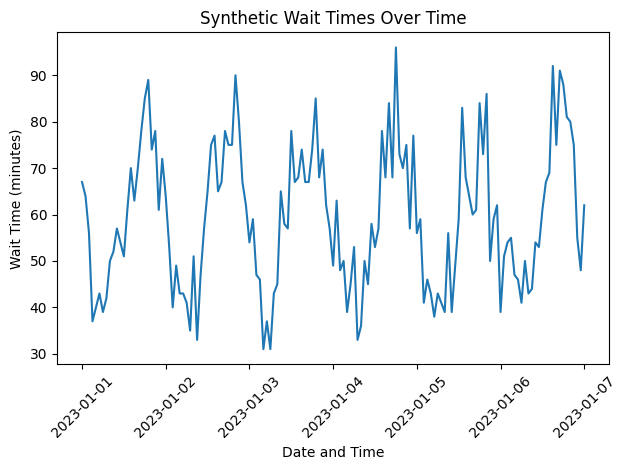

In [12]:
# Plot the synthetic data to see how the wait times fluctuate
sns.lineplot(data=df, x=df.index, y="wait_time_minutes")
plt.title("Synthetic Wait Times Over Time")
plt.xlabel("Date and Time")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Check the average wait time in the generated data
print("Average Wait Time:", df["wait_time_minutes"].mean())

Average Wait Time: 59.33793103448276
